# Dataset

In [1]:
import torch
#Dataset
from torchvision.datasets import MNIST
#Transform
from torchvision.transforms import ToTensor
#Utils
from torch.utils.data import random_split

#Carga de datos
#Datos para entrenamiento
total_training_data = MNIST(root="data", train=True, download=True, transform=ToTensor())
total_len = len(total_training_data)
print(total_len)

training_data, validation_data = random_split(total_training_data, [int(total_len*5/6), int(total_len/6)])
print("Training data: {}".format(len(training_data)))
print("Validation data: {}".format(len(validation_data)))

#Datos para evaluación
test_data = MNIST(root="data", train=False, download=True, transform=ToTensor())
print("Test data: {}".format(len(test_data)))

60000
Training data: 50000
Validation data: 10000
Test data: 10000


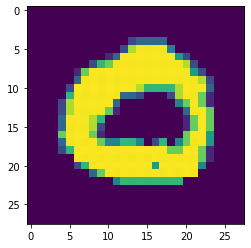

In [2]:
import matplotlib.pyplot as plt

#Se muestra el primer elemento del conjunto de entrenamiento
image, label = training_data[89]
plt.imshow(image.squeeze())

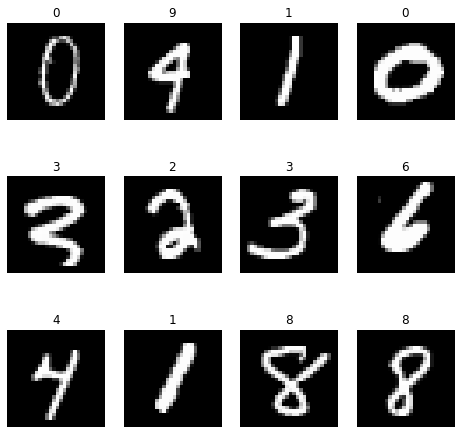

In [3]:
#Etiquetas
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
#Se muestran elementos al azar del conjunto de entrenamiento junto a su etiqueta
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 3
for i in range(1, cols * rows + 1):
    #Se escoge una muestra aleatoria
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Dataloader

In [4]:
#DataLoader
from torch.utils.data import DataLoader

#Se insertan los elementos en un objeto DataLoader
#para facilitar el acceso a ellos 
batch = 100
training_dataloader = DataLoader(training_data, batch_size = batch, shuffle = False)
validation_dataloader = DataLoader(validation_data, batch_size = batch, shuffle = False)
test_dataloader = DataLoader(test_data, batch_size = batch, shuffle = False)


# Model

In [5]:
#Neuronal network model
import torch.nn as nn
import torch.nn.functional as F

#Para crear una red neuronal es obligatorio heredar de la clase nn.Module
#Esta clase crea un red neuronal con las capas, el número de neuronas por capa
#y el dropout que se fije.
class MyNN(nn.Module):

    def __init__(self, layers: int, neurons: tuple, dropout: nn.Dropout = None):
        """
        Parameters
        ----------
        layers: int
            number of hidden layers of the neural network
        neurons: tuple
            number of neurons in each layer
        dropout: nn.Dropout
            activate dropout or not.
            Example: nn.Dropout
        """
        super().__init__()
        self.layers = nn.Sequential()
        for i in range(layers):
            actual_layer = nn.Linear(neurons[i], neurons[i+1])
            self.layers.append(actual_layer)
            # Dropout
            if dropout:
                self.layers.append(dropout)
            #Funcion de activacion ReLu
            self.layers.append(nn.ReLU())
            
    
    def forward(self, x):
        #Primero hay que transformar la imagen a vector
        output = x.view(-1, 28*28)
        output = self.layers(output)
        return output

## Training

### Training Function

In [130]:
#Training function
# El entrenamiento necesita el dataset, el modelo, la función de error y el optimizador
def train_MNIST(training_dataset: DataLoader, model: MyNN, 
                loss_fn: nn.CrossEntropyLoss, optimizer: optim.Adam) -> float:

    #Training

    #Primero se coloca el modelo en modo train
    model.train()
    total_loss = 0
    for inputs, labels in training_dataset:

        #Ejecutar modelo
        predictions = model(inputs)
        #Evaluar loss
        loss = loss_fn(predictions, labels)
        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        #Optimizar
        optimizer.step()
        #Guardar loss actual
        total_loss += loss.item()
    
    num_batches = len(training_dataset)
    return total_loss/num_batches
    

### Validation Function

In [9]:
# La validación necesita el dataset, el modelo, el nombre del modelo y la función de error
def validation_MNIST(validation_dataset: DataLoader, model: MyNN,  
                    loss_fn: nn.CrossEntropyLoss) -> float:

    #Validation
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for inputs, labels in validation_dataset:
            
            #Ejecuto modelo
            predictions = model(inputs)
            #Calculo error
            loss = loss_fn(predictions, labels)
            total_loss += loss.item()

        num_batches = len(validation_dataset)
        return total_loss/num_batches

### Epochs Training

In [131]:
##### Entrenamiento #####
import math

def epochs_training(epochs: int, train_dataloader: DataLoader, val_dataloader: DataLoader, 
                    model: MyNN, loss_fn: nn.CrossEntropyLoss, optim: optim):

    losses = []
    losses_val = []
    min_loss = math.inf
    best_model = None
    
    for epoch in range(epochs):
        #Train
        train_loss = train_MNIST(train_dataloader, model, loss_fn, optim)
        #Validation
        val_loss = validation_MNIST(val_dataloader, model, loss_fn)

        print("Epoch: {} - Train Loss: {:.6f} - Validation Loss: {:.6f}".format(
            epoch+1, train_loss, val_loss))
        
        #Se guarda modelo con menor loss
        if val_loss < min_loss:
            min_loss = val_loss
            #Guardar modelo
            best_model = model.state_dict()
            #torch.save(best_model, "model.pt")

        losses.append(train_loss)
        losses_val.append(val_loss)

    return losses, losses_val, best_model

## Test

In [127]:
from sklearn.metrics import accuracy_score

def test_MNIST(test_dataset: DataLoader, model: MyNN, loss_fn: nn.CrossEntropyLoss):
    #Red en modo test (eval)
    model.eval()
    #Listas de almacenamiento
    total_loss = 0
    all_labels = torch.Tensor()
    all_predictions = torch.Tensor()
    #correct = 0

    with torch.no_grad():
        #Primero se debe trabajar con los batch de elementos
        for inputs, labels in test_dataset:
            
            #Evaluar red
            predictions = model(inputs)
            #Calcular error entre predicciones y etiquetas
            loss = loss_fn(predictions, labels)
            #Backpropagation X
            #Optimizar X

            #Calcular accuracy (precision)

            #for i in range(len(labels)):
            #    #print(predictions[i].argmax(), labels[i])
            #    if predictions[i].argmax() == labels[i]:
            #        correct += 1

            all_labels = torch.cat((all_labels, labels), dim=0)
            all_predictions = torch.cat((all_predictions, predictions.argmax(1)), dim=0)
            #accuracy += correct/len(labels)
            #print(accuracy)

            #Almacenar loss y accuracy
            total_loss += loss.item()
    
    accuracy = accuracy_score(all_labels, all_predictions)
    num_batches = len(test_dataset)
    return {'loss': total_loss/num_batches, 'accuracy': accuracy*100}



## Results

### Plot Function

In [11]:
import numpy as np

#Función para generar gráficos
def loss_plotter(ax: plt.Axes, epochs_list, losses_train, losses_val):
    """
    A helper function to make a graph.
    """
    epochs = len(epochs_list)
    ax.set_title("Loss vs época")
    ax.set_xlabel("Época")
    ax.set_ylabel("Loss")
    ax.set_xticks(np.arange(2, epochs+1, 2))
    ax.set_xlim(0, epochs + 1)
    ax.plot(epochs_list, losses_train, marker='o', label='Train')
    out_plot = ax.plot(epochs_list, losses_val, marker='*', label='Validation')
    ax.legend()
    return out_plot

### Confusion Matrix Function

In [110]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def confusion_matrix_MNIST(test_dataset: DataLoader, model: MyNN, title: str =''):
    #Red en modo test (eval)
    model.eval()
    #Listas de almacenamiento
    all_predictions = torch.Tensor()
    all_labels = torch.Tensor()

    with torch.no_grad():
        #Primero se debe trabajar con los batch de elementos
        for inputs, labels in test_dataset:
            
            #Evaluar red
            predictions = model(inputs)
            #Calcular error entre predicciones y etiquetas X
            #Backpropagation X
            #Optimizar X
            predictions = predictions.argmax(1)
            #print(labels)
            #print(predictions)
            all_predictions = torch.cat((all_predictions, predictions), dim = 0)
            all_labels = torch.cat((all_labels, labels), dim = 0)
    
    cm = confusion_matrix(all_labels, all_predictions, 
                        labels= list(range(0, 10)), normalize='true')
    fig, ax = plt.subplots()
    fig.set_size_inches(10,8)
    ax.set_title(title)
    cm = ConfusionMatrixDisplay.from_predictions(all_labels, all_predictions,
                                labels=list(range(0, 10)), normalize='true',
                                ax=ax)
    return fig

# Networks

In [ ]:
#Neurons
input_n = 28*28
hidden = 100
output_n = 10

nn_model_1layer = MyNN(layers = 1, neurons = (input_n, output_n))
nn_model_2layer = MyNN(layers = 2, neurons = (input_n, hidden, output_n))
nn_model_1layer_regL2 = MyNN(layers = 1, neurons = (input_n, output_n))
nn_model_1layer_dropout = MyNN(layers = 1, neurons = (input_n, output_n), dropout = nn.Dropout())

print("1 layer:")
print(nn_model_1layer)

print("2 layer:")
print(nn_model_2layer)

print("1 layer dropout:")
print(nn_model_1layer_dropout)

## Optimize

In [7]:
import torch.optim as optim
#Optimizer
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2*1e-4
optim_1layer = optim.Adam(nn_model_1layer.parameters(), lr=learning_rate)
optim_2layer = optim.Adam(nn_model_2layer.parameters(), lr=learning_rate)
optim_1layer_regL2 = optim.Adam(nn_model_1layer_regL2.parameters(), lr=learning_rate, 
                            weight_decay=0.5)
optim_1layer_dropout = optim.Adam(nn_model_1layer_dropout.parameters(), lr=learning_rate)


In [12]:
import pickle

epochs = 20
epochs_list = np.arange(1, epochs+1)


## 1 Layer Neural Network

### Carga de modelo

In [132]:
#Se cargan si están guardados
import pickle

#Cargar losses
with open('losses_1layer.pkl', 'rb') as l:
    losses_1layer = pickle.load(l)

print('Losses', losses_1layer)

with open('losses_1layer_val.pkl', 'rb') as l:
    losses_1layer_val = pickle.load(l)

print('Losses', losses_1layer_val)

#Cargar modelo
nn_model_1layer.load_state_dict(torch.load('model_1layer.pt'))
print('State Dict')
print(nn_model_1layer.state_dict())

Losses [1.453238818526268, 0.8975136140584946, 0.7516856009960174, 0.6814111783504486, 0.639093763589859, 0.6104502834677696, 0.5896371367573738, 0.5738126760721207, 0.5613633807301521, 0.5512685794830322, 0.5429275698661804, 0.5359073567986489, 0.5299250652194023, 0.5247503795027733, 0.5202226772904396, 0.5161969442367553, 0.5126135250329972, 0.5093915712833404, 0.5064764283299447, 0.5038039062023163]
Losses [1.0334106910228729, 0.8059178328514099, 0.71268539249897, 0.6612471285462379, 0.6283605456352234, 0.6055069571733475, 0.5886118337512016, 0.5756767871975899, 0.565459997355938, 0.5571826675534248, 0.5503925096988678, 0.5446715337038041, 0.5397623547911644, 0.5355802100896835, 0.5319104546308517, 0.5286987367272377, 0.525813969373703, 0.5232550665736199, 0.5209590643644333, 0.5188987550139427]
State Dict
OrderedDict([('layers.0.weight', tensor([[ 0.0172,  0.0324,  0.0249,  ...,  0.0111, -0.0076,  0.0325],
        [-0.0269, -0.0184,  0.0254,  ...,  0.0054,  0.0320, -0.0351],
      

### Entrenamiento

In [135]:
### Entrenamiento ###

#Se crea la red y el optimizador
nn_model_1layer = MyNN(layers = 1, neurons = (input_n, output_n))
optim_1layer = optim.Adam(nn_model_1layer.parameters(), lr=learning_rate)

#Se entrena
losses_1layer, losses_1layer_val, best_model_1layer = epochs_training(20,  
                                                        training_dataloader, validation_dataloader,
                                                        nn_model_1layer, loss_fn, optim_1layer)

Epoch: 1 - Train Loss: 1.312999 - Validation Loss: 0.812380
Epoch: 2 - Train Loss: 0.663297 - Validation Loss: 0.564163
Epoch: 3 - Train Loss: 0.509594 - Validation Loss: 0.470053
Epoch: 4 - Train Loss: 0.440246 - Validation Loss: 0.419884
Epoch: 5 - Train Loss: 0.400027 - Validation Loss: 0.388358
Epoch: 6 - Train Loss: 0.373532 - Validation Loss: 0.366674
Epoch: 7 - Train Loss: 0.354694 - Validation Loss: 0.350803
Epoch: 8 - Train Loss: 0.340572 - Validation Loss: 0.338696
Epoch: 9 - Train Loss: 0.329580 - Validation Loss: 0.329139
Epoch: 10 - Train Loss: 0.320769 - Validation Loss: 0.321456
Epoch: 11 - Train Loss: 0.313547 - Validation Loss: 0.315134
Epoch: 12 - Train Loss: 0.307514 - Validation Loss: 0.309838
Epoch: 13 - Train Loss: 0.302369 - Validation Loss: 0.305347
Epoch: 14 - Train Loss: 0.297927 - Validation Loss: 0.301478
Epoch: 15 - Train Loss: 0.294048 - Validation Loss: 0.298111
Epoch: 16 - Train Loss: 0.290616 - Validation Loss: 0.295136
Epoch: 17 - Train Loss: 0.287550 

In [139]:
#Guardar mejor modelo
torch.save(best_model_1layer, "model_1layer.pt")
print(losses_1layer)
print(losses_1layer_val)
#Guardar losses
with open('losses_1layer.pkl', 'wb') as l:
    pickle.dump(losses_1layer, l)
with open('losses_1layer_val.pkl', 'wb') as l:
    pickle.dump(losses_1layer_val, l)

[1.3129987030029298, 0.6632965086698532, 0.5095944277644158, 0.44024581742286684, 0.4000269418656826, 0.3735318301618099, 0.35469428458809854, 0.34057178276777267, 0.3295797506570816, 0.3207690506875515, 0.3135468944311142, 0.30751376968622207, 0.3023685605674982, 0.2979271937459707, 0.2940477225035429, 0.2906163672506809, 0.28754958394169805, 0.2847842773348093, 0.28226814658939836, 0.2799527724385262]
[0.8123797124624252, 0.564163111448288, 0.4700528162717819, 0.4198837113380432, 0.38835813716053963, 0.36667362600564957, 0.3508030842244625, 0.3386961618065834, 0.32913917034864426, 0.32145568639039995, 0.3151335881650448, 0.3098380249738693, 0.30534698083996775, 0.30147812113165856, 0.29811066180467605, 0.29513619527220725, 0.2924809128046036, 0.2901227137446403, 0.287971565425396, 0.2860199773311615]


### Gráfico

Text(0.5, 1.0, 'Loss vs época en red de 1 capa')

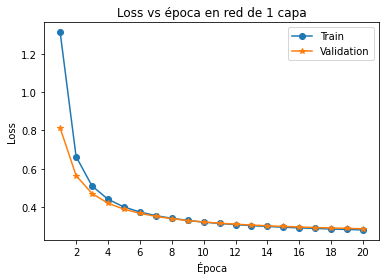

In [140]:
#Grafico entrenamiento
fig, ax = plt.subplots()
losses_1layer_plot = loss_plotter(ax, epochs_list, np.array(losses_1layer), 
                    np.array(losses_1layer_val))
ax.set_title("Loss vs época en red de 1 capa")

### Test

Loss en test: 0.27580 - Accuracy: 92.31%


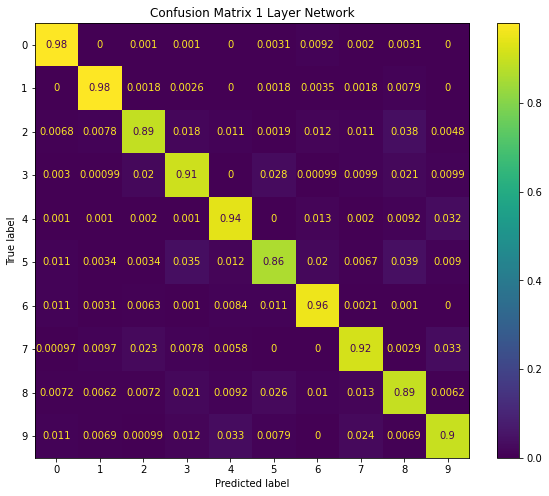

In [141]:
test_1layer = test_MNIST(test_dataloader, nn_model_1layer, loss_fn)
print('Loss en test: {loss:.5f} - Accuracy: {accuracy:.2f}%'.format(**test_1layer))

cm_1layer = confusion_matrix_MNIST(test_dataloader, nn_model_1layer, 
                                    'Confusion Matrix 1 Layer Network')

## 2 Layer Neural Network

### Carga de modelo

In [ ]:
#Se cargan si están guardados
import pickle

#Cargar losses
with open('losses_2layer.pkl', 'rb') as l:
    losses_2layer = pickle.load(l)

print('Losses', losses_1layer)

with open('losses_2layer_val.pkl', 'rb') as l:
    losses_2layer_val = pickle.load(l)

print('Losses', losses_2layer_val)

#Cargar modelo
nn_model_2layer.load_state_dict(torch.load('model_2layer.pt'))
print('State Dict')
print(nn_model_2layer.state_dict())

### Entrenamiento

In [ ]:
### Entrenamiento ###

#Se crea la red y el optimizador
nn_model_2layer = MyNN(layers = 2, neurons = (input_n, hidden, output_n))
optim_2layer = optim.Adam(nn_model_2layer.parameters(), lr=learning_rate)

#Se entrena
losses_2layer, losses_2layer_val, best_model_2layer = epochs_training(20,  
                                                        training_dataloader, validation_dataloader,
                                                        nn_model_2layer, loss_fn, optim_2layer)

In [ ]:
#Guardar mejor modelo
torch.save(best_model_2layer, "model_2layer.pt")
print(losses_2layer)
print(losses_2layer_val)
#Guardar losses
with open('losses_2layer.pkl', 'wb') as l:
    pickle.dump(losses_2layer, l)
with open('losses_2layer_val.pkl', 'wb') as l:
    pickle.dump(losses_2layer_val, l)

### Gráfico

In [ ]:
#Grafico entrenamiento
fig, ax = plt.subplots()
losses_2layer_plot = loss_plotter(ax, epochs_list, np.array(losses_2layer), 
                    np.array(losses_2layer_val))
ax.set_title("Loss vs época en red de 2 capas")

### Test

In [ ]:
test_2layer = test_MNIST(test_dataloader, nn_model_2layer, loss_fn)
print('Loss en test: {loss:.5f} - Accuracy: {accuracy:.2f}%'.format(**test_2layer))

cm_2layer = confusion_matrix_MNIST(test_dataloader, nn_model_2layer, 
                                    'Confusion Matrix 1 Layer Network')